# Tutorial: Simple Fishing Game

To get you started, I defined a super-simple fishing game, based on the first three locations
in __Action Castle__, which is a text adventure game in a fun book by Jared A. Sorensen called
[Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).


<img src="tutorial-map.png" width="500"/>



The goal of this game is simple: help your character find some food to eat because they are hungry!

## The Text Adventures Library

We will be using a framework designed for this class called _Text Adventures_, which is included in this repo.

### High-Level

The main concepts we are concerned with when building a game with Text Adventures are:

* Things: _locations, items, and characters_
* Actions: things a character can do
* Blocks: things that prevent a character from going somewhere
* Commands: how a user interacts with the game

### Things

_Things_ can have _properties_. A property is some detail about the thing that influences how other things can interact with it. A poisonous potion might have the property `is_poisonous` set, or a locked door might have `is_locked` set. Properties are designed to be flexible and easily extensible without significant code changes.

_Things_ can also have commands associated with them. A rosebush might have a command that lets characters pick a rose from the bush, and that rose might have a command for smelling it.

All _things_ are stored in `text_adventures.things`.

### Actions

An action is something a user does to change the game's state, such as changing location, eating food, or attacking something.

When a user enters a command, the game will parse the command to determine its intent and route it to the appropriate action. This means a user can type _go west_ and the game will work out that this means `text_adventures.actions.Go` and it will determine if the character can move west based on where the character is.

The game's state might change each time an action is executed, so action instances are created for each command and the game's state is re-evaluated to determine if the action will be successful or fail.

### Blocks

Blocks are useful for implementing things like a locked door or if some direction is guarded by a monster.

If a user attempts to enter a location that is blocked from where they are, the command will fail with some information about why. It's up to the game designer as to whether or not a block can be removed.

### Install required libraries

In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Import Text Adventures

In [2]:
# If a folder has a "__init__.py" in it, even if that is empty, Python treats it as a package
# Inside that package:
    # a .py file is a treated as a Module 
    # a folder with its own "__init__.py" file is a subpackage
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

A location is a place that characters can go to. Locations can be connected to other locations, creating a graph of places to visit, eg. the game map.

The 3 locations from **Action Castle** are:

* a cottage, your home
* a garden path
* a pond where you can fish to the south

In [3]:
cottage = things.Location(
    "Cottage",
    "You are standing in a small cottage."
)

garden_path = things.Location(
    "Garden Path",
    "You are standing on a lush garden path. There is a cottage here.",
)

fishing_pond = things.Location(
    "Fishing Pond",
    "You are at the edge of a small fishing pond."
)

We'll also add a 4th location, a cliff. If the player visits the cliff, they will fall off and that will end the game, so be careful!

**Note**: the `game_over` property is set on the cliff.

In [4]:
cliff = things.Location(
    "Cliff",
    "There is a steep cliff here. You fall off the cliff and lose the game. THE END",
)
cliff.set_property("game_over", True)  # RIP 🪦☠️

### Connecting Locations

From the cottage you can go _out_ to the garden path, and from there you can go _west_ to a cliff or _south_ to a fishing pond.


In [5]:
# Cottage -> Garden Path
cottage.add_connection("out", garden_path)

# Garden Path -> Fishing Pond
garden_path.add_connection("south", fishing_pond)

# Garden Path -> Cliff
garden_path.add_connection("east", cliff)

**NOTE**: Being able to go _out_ implies that you can also go _in_ from the other direction. The Text Adventures framework will account for that automatically when you use one of the following pairs:

* north/south
* east/west
* up/down
* in/out
* inside/outside

## Items

Items can be placed at locations or they can be placed in a character's inventory. Any details about the item that may be interesting should be added as properties.

### Gettable Items

A _gettable_ item is an item that a character can put in their inventory using the _get_ command.

In [6]:
# Put a fishing pole in the cottage
fishing_pole = things.Item(
    "pole",
    "a fishing pole",
    "A SIMPLE FISHING POLE.",
)
cottage.add_item(fishing_pole)

# Put a deadly potion in the cottage
potion = things.Item(
    "potion",
    "a poisonous potion",
    "IT'S BRIGHT GREEN AND STEAMING.",
)

potion.set_property("is_drink", True)
potion.set_property("is_poisonous", True)
potion.add_command_hint("drink potion")
cottage.add_item(potion) 

### Non-gettable Items

Non-gettable items are things that exist at locations but can't be picked up, like a pond. Notice that the `gettable` property is set to False.

In [7]:
# Put an actual pond as an item at the fishing pond location
# Making the Item 
pond = things.Item(
    "pond",
    "a small fishing pond",
    "THERE ARE FISH IN THE POND.",
)
pond.set_property("gettable", False)
pond.set_property("has_fish", True)
pond.add_command_hint("catch fish")
pond.add_command_hint("catch fish with pole")
# Adding to fishing pond
fishing_pond.add_item(pond)


# Put a rosebush as an item in the garden

# Making the Item 
rosebush = things.Item(
    "rosebush",
    "a rosebush",
    "THE ROSEBUSH CONTAINS A SINGLE RED ROSE.  IT IS BEAUTIFUL.",
)
rosebush.set_property("gettable", False)
rosebush.set_property("has_rose", True)
rosebush.add_command_hint("pick rose")
# Adding to fishing pond
garden_path.add_item(rosebush)


## Characters

A character is some living thing that can perform actions, such as your player, or maybe a mean troll, or perhaps a princess. They can have properties applied to them too, which we'll see when the game sets `is_hungry` on our player below.

In later homeworks we will develop characters more fully so that you can interact with them and they have their own goals and pursue their own interests in the game.

In [8]:
player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)


## The Game

The game class, defined in `text_adventures.games`:

- list of characters, one designated as player
- all locations in the game
- special function to determine if game has been won
- functions for saving and loading game states, which we'll see later.
- a game loop that runs the game, interacting with the user via commands

To create our fishing game, we will subclass `Game` and define the `is_won` function to check when the game is won. In this case, the player starts out hungry, shown by calling `set_property` on the player.

In [9]:
class FishingGame(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)
        self.player.set_property("is_hungry", True)

    def is_won(self) -> bool:
        """ 
        Checks whether the player has won the game.  
        For the fishing mini game, this means that the player is no longer hungry.
        """
        if not self.player.get_property("is_hungry"):
            self.parser.ok("You are no longer hungry. You win!")
            return True
        else:
            return False

## Commands

In text adventure games the user types in simple natural language commands to interact with the game environment. That text is parsed for meaning and actions may or may not take place as a result.

One of the challenges for the parser is mapping the language to corresponding components of the game. Classic text adventure games use simple two word commands, eg. _go east_ or _get pole_.

In the next section, you will see five commands that will guide you through our game.

## Let's Play!

*Behold, as a magestic prompt appears!*

You can play through the whole game with the following commands:

1. take pole
2. go out
3. south
4. catch fish with pole
5. eat fish

In [10]:
game = FishingGame(cottage, player)

game.game_loop()

You are standing in a small cottage.
Exits:
Out to Garden Path

You see:
 * a fishing pole
 * a poisonous potion
        drink potion


I'm not sure what you want to do.
The player got the pole.
You are standing on a lush garden path. There is a cottage here.
Exits:
In to Cottage
South to Fishing Pond
East to Cliff

You see:
 * a rosebush
        pick rose


You are at the edge of a small fishing pond.
Exits:
North to Garden Path

You see:
 * a small fishing pond
        catch fish
        catch fish with pole


The player reaches into the pond and tries to catch a fish with their hands, but
the fish are too fast.
You don't have it.
The player reaches into the pond and tries to catch a fish with their hands, but
the fish are too fast.
The player dips their hook into the pond and catches a fish
The player eats the fish. It tastes disgusting! It's raw! And definitely not
sashimi-grade!
You are no longer hungry. You win!


### Visualize Game

One way of conceptualizing our games is as a directed graph, where nodes are locations connected via directed arcs.  We can vizualize our game as a directed graph.

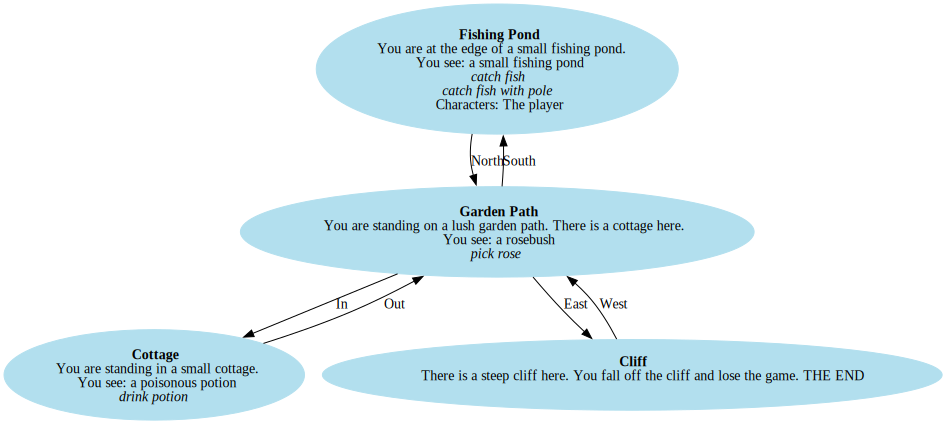

In [11]:
from text_adventure_games.viz import Visualizer
viz = Visualizer(game)
graph = viz.visualize()
graph

## Action

You can define your own custom actions for the game. Actions consist of two of three parts:

* the intitialization: which parses the arguments
* the preconditions: which determine if the action can be applied
* the effect: which change the state of the game when the action is successfully applied

In [ ]:
class Cook(actions.Action):
    # Updating a copy of these class attributes gotten from the parent class "Action"
    ACTION_NAME = 'cook'
    ACTION_DESCRIPTION = 'Cook some food'

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command
        self.character = self.parser.get_character(command)
        self.food = self.parser.match_item(
            command, self.parser.get_items_in_scope(self.character)
        )

    def check_preconditions(self) -> bool:
        if not self.food:
            self.parser.fail("No food found")
        if not self.food.get_property("is_food"):
            self.parser.fail(f"{self.food.name} is not food")
            return False
        return True

    def apply_effects(self):
        self.food.set_property("taste", "deliciously cooked")
        self.parser.ok(f"You cooked the {self.food.name}")


### Simple Cooking Game

In [ ]:
fishing_pond = things.Location(
    "Fishing Pond",
    "You are at the edge of a small fishing pond."
)

pond = things.Item(
    "pond",
    "a small fishing pond",
    "THERE ARE FISH IN THE POND.",
)

pond.set_property("gettable", False)
pond.set_property("has_fish", True)
pond.add_command_hint("catch fish")
pond.add_command_hint("catch fish with pole")
fishing_pond.add_item(pond)


player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)

fishing_pole = things.Item(
    "pole",
    "a fishing pole",
    "A SIMPLE FISHING POLE.",
)
player.add_to_inventory(fishing_pole)


### Using Custom Action in a Game

To use custom actions, pass them as arguments to the game's constructor.

In [14]:
game = FishingGame(fishing_pond, player, custom_actions=[Cook])

game.game_loop()

You are at the edge of a small fishing pond.

You see:
 * a small fishing pond
        catch fish
        catch fish with pole


I'm not sure what you want to do.
I'm not sure what you want to do.


KeyboardInterrupt: Interrupted by user

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b16fb3c8-85ab-4463-b29e-8658c8738191' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>